# Deep Learning

_May your choices reflect your hopes, not your fears_ – Nelson Mandela

We explore the application of deep learning techniques for text classification, specifically focusing on categorizing US companies based on their industry sectors. Using business description texts extracted from SEC 10-K filings, we apply natural language processing (NLP) methods and deep averaging networks (DAN) to classify firms according to the Fama-French 10-sector scheme. The analysis includes preprocessing textual data, leveraging pre-trained word embeddings for semantic representation, and evaluating various training strategies to optimize predictive accuracy and generalization performance.

In [1]:
# By: Terence Lim, 2020-2025 (terence-lim.github.io)
import numpy as np
import random
import time
import pandas as pd
from pandas import DataFrame, Series
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import seaborn as sns
from tqdm import tqdm
import torch
from torch import nn
import torchinfo
from textblob import TextBlob
from tqdm import tqdm
from finds.database import SQL, RedisDB
from finds.unstructured import Edgar, Vocab
from finds.structured import BusDay, CRSP, PSTAT
from finds.readers import Sectoring
from finds.utils import Store
from secret import credentials, paths, CRSP_DATE
VERBOSE = 0
outdir = paths['scratch']
store = Store(outdir, ext='pkl')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"{device=}")
print(f"{torch.cuda.is_available()=}")      # Should return True
print(f"{torch.cuda.device_count()=}")      # Number of available GPUs
print(f"{torch.cuda.current_device()=}")    # Current GPU index
print(f"{torch.cuda.get_device_name(0)=}")  # Name of the GPU

device=device(type='cuda')
torch.cuda.is_available()=True
torch.cuda.device_count()=1
torch.cuda.current_device()=0
torch.cuda.get_device_name(0)='NVIDIA GeForce RTX 3080 Laptop GPU'


In [2]:
sql = SQL(**credentials['sql'], verbose=VERBOSE)
user = SQL(**credentials['user'], verbose=VERBOSE)
bd = BusDay(sql)
rdb = RedisDB(**credentials['redis'])
crsp = CRSP(sql, bd, rdb, verbose=VERBOSE)
pstat = PSTAT(sql, bd, verbose=VERBOSE)
ed = Edgar(paths['10X'], zipped=True, verbose=VERBOSE)

## Industry text classification

We begin by extracting a universe of US-domiciled common stocks at the start of the most recent year, along with their corresponding 10-K business descriptions from SEC filings. The target categories for our text classification task are drawn from the Fama-French 10-sector classification scheme.

In [30]:
# Retrieve universe of stocks as of start of latest year
univ = crsp.get_universe(bd.endmo(CRSP_DATE-10000))
CRSP_DATE

20241231

In [4]:
# lookup company names
comnam = crsp.build_lookup(source='permno', target='comnam', fillna="")
univ['comnam'] = comnam(univ.index)

In [5]:
# lookup ticker symbols
ticker = crsp.build_lookup(source='permno', target='ticker', fillna="")
univ['ticker'] = ticker(univ.index)

In [6]:
# lookup sic codes from Compustat, and map to FF 10-sector code
sic = pstat.build_lookup(source='lpermno', target='sic', fillna=0)
industry = Series(sic[univ.index], index=univ.index)
industry = industry.where(industry > 0, univ['siccd'])
sectors = Sectoring(sql, scheme='codes10', fillna='')   # supplement from crosswalk
univ['sector'] = sectors[industry]

In [9]:
# retrieve 2023 10K business descriptions text
item, form = 'bus10K', '10-K'
rows = DataFrame(ed.open(form=form, item=item))
found = rows[rows['date'].between(bd.begyr(CRSP_DATE), bd.endyr(CRSP_DATE))]\
             .drop_duplicates(subset=['permno'], keep='last')\
             .set_index('permno')

### Textblob


The `TextBlob` library simplifies common NLP tasks such as part-of-speech tagging, lemmatization, noun phrase extraction, sentiment analysis, and spelling correction. It provides friendly access to functionalities derived from NLTK and integrates with WordNet. 

- https://textblob.readthedocs.io/en/dev/quickstart.html

For our task, TextBlob is employed to tokenize business descriptions and extract nouns. We filter the documents to retain only those containing at least 100 valid nouns to ensure robust semantic representation.

In [10]:
bus = {}
for permno in tqdm(found.index):
    if permno not in univ.index:
        continue
    doc = TextBlob(ed[found.loc[permno, 'pathname']].lower())  # tokenize and tag
    nouns = [word for word, tag in doc.tags
             if tag in ['NN', 'NNS'] and word.isalpha() and len(word) > 2]
    if len(nouns) > 100:
        bus[permno] = nouns
permnos = list(bus.keys())

100%|██████████| 4488/4488 [17:23<00:00,  4.30it/s]


### Word Embeddings

Word embeddings are dense, numerical vector representations capturing semantic and syntactic meanings of words. These embeddings place words into a continuous vector space, positioning semantically similar or related words closely together. Word embeddings can be generated through neural network-based approaches or matrix factorization methods.

1. **Word2Vec** (Mikolov et al., 2013):
   Word2Vec utilizes shallow neural networks, usually comprising a single hidden layer, to learn embeddings from textual data. It has two primary training approaches:
   - **Skip-gram**: Predicts context words given a center word, effectively capturing representations of rare words.
   - **Continuous Bag of Words (CBOW)**: Predicts a center word from surrounding context words, typically faster and better for frequent words.

2. **GloVe (Global Vectors for Word Representation)** (Pennington et al., 2014):
   GloVe generates embeddings based on matrix factorization of global word-word co-occurrence statistics. Unlike Word2Vec, which relies on local context predictions, GloVe considers overall word pair co-occurrences, resulting in globally consistent embeddings.

Pre-trained GloVe vectors (300-dimensional) are utilized to represent the extracted words as embeddings.


In [11]:
# Load GloVe embeddings, source: "https://nlp.stanford.edu/data/glove.6B.zip"
embeddings_dim = 300  # dimension of GloVe embeddings vector

filename = paths['scratch'] / f"glove.6B.{embeddings_dim}d.txt.zip"
embeddings = pd.read_csv(filename, sep=" ", quoting=3,
                         header=None, index_col=0, low_memory=True)
embeddings.index = embeddings.index.astype(str).str.lower()
print(embeddings.shape)


(400000, 300)


### Word vector arithmetic

Word embeddings reflect linguistic relationships through geometric relationships in vector space. Embeddings can be arithmetically combined and manipulated to uncover analogies and semantic similarities. However, these mathematical relationships are generally approximate and can highlight potential biases inherent in training data, such as implicit gender biases.


In [12]:
from sklearn.neighbors import NearestNeighbors
analogies = ["man king woman", "paris france tokyo", "big bigger cold"]
for analogy in analogies:
    words = analogy.lower().split()
    vectors = {word: embeddings.loc[word].values for word in words}
    vec = vectors[words[1]] - vectors[words[0]] + vectors[words[2]]

    sim = NearestNeighbors(n_neighbors=1).fit(embeddings)
    neighbors = sim.kneighbors(vec.reshape((1, -1)), n_neighbors=2,
                               return_distance=False).flatten().tolist()
    neighbors = [k for k in neighbors if embeddings.index[k] not in words]
    print(f"{words[1]} - {words[0]} + {words[2]} =",
          [embeddings.index[k] for k in neighbors])

king - man + woman = ['queen']
france - paris + tokyo = ['japan']
bigger - big + cold = ['colder']


### Data preparation

We construct a custom vocabulary (`Vocab`) mapping each word to an index, encoding each document as a list of these indices. The pre-trained GloVe embedding matrix is adapted to include only words present in our corpus-specific vocabulary. Sector labels are converted into numerical values using LabelEncoder. The dataset is then stratified and split into training and testing subsets to maintain balanced class distributions.

In [13]:
words = Counter()
for nouns in bus.values():
    words.update(list(nouns))
vocab = Vocab(words.keys())
print('vocab len:', len(vocab))

vocab len: 85891


In [14]:
labels = []
x_all = []
for permno, nouns in bus.items():
    x = vocab.get_index([noun for noun in nouns])
    if sum(x):
        labels.append(univ.loc[permno, 'sector'])
        x_all.append(x)
class_encoder = LabelEncoder().fit(labels)    # .inverse_transform()
y_all = class_encoder.transform(labels)

In [15]:
store['dan'] = dict(y_all=y_all, x_all=x_all)

In [16]:
# retrieve from previously stored
y_all, x_all = store['dan'].values()

In [17]:
# relativize embeddings to words in vocab
vocab.set_embeddings(embeddings)
print(vocab.embeddings.shape)

(85891, 300)


In [18]:
vocab.dump(outdir / f"dan{embeddings_dim}.pkl")

In [19]:
# load vocab
vocab.load(outdir / f"dan{embeddings_dim}.pkl")

## Feedforward neural networks

Neural networks are computational models inspired by the human brain. They are built from layers of simple computational units that transform input data to output predictions.  Deep neural networks alternate between linear layers and non-linear activations, and can approximate any continuous function (Universal Approximation Theorem).

- __Neurons__ are the basic computational units or nodes of a neural network.
  Each neuron receives input, processes it using a weighted sum and a bias term, and then applies an activation function to produce an output, which is then passed to the neurons in the next layer.

- __Activation functions__ are the nonlinear mathematical functions applied to neurons in a neural network. They introduce non-linearity into the model, enabling it to learn and represent complex patterns in the data. Common activation functions include ReLU (Rectified Linear Unit), sigmoid, and tanh.

- __Input Layer__ is the first layer of a neural network which directly receives the input data. Each neuron in the input layer represents one feature of the input.
  
- __Hidden Layers__, between the input layer and the output layer, take input from the previous layer of neurons, apply weights, biases, and activation functions, and pass the output to the next layer.

- __Output Layer__ is the final layer of the neural network and it produces the network’s output. Its neurons represent the predictions or classifications made by the network. The number of neurons in the output layer corresponds to the number of output classes or the dimensionality of the output. For classification tasks, softmax or sigmoid functions are often used in the output layer to provide probability distributions of the class predictions.


__Feedforward neural networks (FFNNs)__ are the simplest form of neural networks, where the data flows in one direction (a forward pass) and the connections do not form a cycle. A **Multilayer Perceptron (MLP)** is a type of FFNN which must has at least one hidden layer: MLPs are composed of an input layer, one or more hidden layers, and an output layer, with non-linear activation functions applied between layers.


**Optimization** is the process of adjusting model parameters to align its predictions with true targets. 

- __Loss function__ measures how well a neural network's output matches the true label or target.
During training, the goal is to minimize this loss. Common loss functions L1 (Mean Absolute Error) and L2 (Mean Squared Error) for regression tasks, and Cross-Entropy for classification tasks.

- __Stochastic Gradient Descent (SGD)__ is an optimization method used to train neural networks by updating parameters using gradients from a single (or small batch of) data point(s) at each step. It allows efficient updates even on massive datasets, with the ability to escape local minima due to its noise.

- __Backpropagation__ is used for training neural networks by updating the weights of neurons based on the error (loss) of the network's predictions: it involves calculating the gradient of the loss function with respect to each weight by using the chain rule of calculus, and propagating these gradients backward from the output layer to the input layer.

- __Computation Graph__ is a graphical representation of the sequence of operations used to compute the forward pass and the backward pass for backpropagation. PyTorch's modules automatically constructs the computation graph and computes gradients, hence simplifying the implementation of neural networks.

- __Initialization__ refers to the process of setting the initial values of the weights in a neural network before training begins. Poor initialization can lead to slow convergence or getting stuck in local minima. Common initialization methods include Xavier (Glorot) and He initialization
 

**Training** deep neural networks involves carefully tuning several key components to ensure effective learning and generalization. 

- __Learning Rate__: If too low, training is slow; too high and loss spikes. A learning rate schedules (e.g. cosine annealing) is more efficient than a fixed learning rate.
  
- __Adam__ (Adaptive Moment Estimation) is an optimization algorithm for training neural networks which improves on stochastic gradient descent and achieves good performance on problems with large, high-dimensional data sets. It adapts the learning rate for each parameter by computing adaptive learning rates from estimates of first and second moments of the gradients. **AdamW** improves the performance of Adam in deep networks by applying weight decay directly to model parameters separately from gradient-based updates.

- __Hyperparameters__ are parameters not learned by the neural network during training. They are set before training and control how the network learns. Examples include: Learning rate (size of each update step in gradient descent); Number of epochs (how many times the model sees the entire dataset); and Model size ( number of layers, units per layer).

- __Batching__ divides the training data into smaller subsets called batches, rather than
training the model on the entire dataset at once, which can be computationally intensive and inefficient. It also gives speedup compared to training the network one sample at a time due to more eﬃcient matrix operations.

- __Dropout__ is a regularization technique during training, where a random subset of neurons is "dropped out" or set to zero at each iteration. This reduces overfitting by ensuring that the model does not rely too heavily on any particular subset of neurons. Geoffrey Hinton, et al. in their 2012 paper that first introduced dropout. They found that using a simple method of 50% dropout for all hidden units and  20% dropout for input units achieve improved results with a range of  neural networks on different problem types. It is not used on the output layer.



### Deep Averaging Networks

**Deep Averaging Network (DAN)** is a straightforward feedforward neural network architecture used for text classification. It averages embeddings of document words and feeds this representation through multiple hidden layers to predict class labels. Key properties include:
- **Embedding Layer**: Uses pre-trained GloVe vectors (frozen or fine-tuned).
- **Fully Connected Layers**: Transform embeddings into classification scores.
- **Nonlinear Activations**: Employ ReLU for non-linearity.
- **Output Layer**: Applies `LogSoftmax` for multi-class predictions.
- **Dropout Layers**: Prevent overfitting.
- **Xavier Initialization**: Stabilizes training.

We investigate training strategies, such as frozen embeddings (fast, prevents overfitting on small data), fine-tuned embeddings (task-specific optimization but resource-intensive), and dropout regularization (enhances generalization).



In [42]:
class DAN(nn.Module):
    """Deep Averaging Network for classification"""
    def __init__(self,
                 vocab_dim,
                 num_classes,
                 hidden,
                 embedding,
                 freeze=True):
        super().__init__()
        self.embedding = nn.EmbeddingBag.from_pretrained(embedding)
        self.embedding.weight.requires_grad = not freeze
        D = nn.Dropout(0.0)
        V = nn.Linear(vocab_dim, hidden[0])
        nn.init.xavier_uniform_(V.weight)
        L = [D, V]
        self.drops = [D]
        for in_dim, out_dim in zip(hidden, hidden[1:] + [num_classes]):
            L.append(nn.ReLU())   # nonlinearity layer
            D = nn.Dropout(0.0)
            self.drops.append(D)
            L.append(D)           # dropout layer
            W = nn.Linear(in_dim, out_dim)   # dense linear layer
            nn.init.xavier_uniform_(W.weight)
            L.append(W)
        self.network = nn.Sequential(*L)
        self.classifier = nn.LogSoftmax(dim=-1)  # output is (N, C) logits

    def set_dropout(self, dropout):
        if dropout:
            self.drops[0].p = 0.2    # input layer
            for i in range(1, len(self.drops)):    # hidden layers
                self.drops[i].p = 0.5
        else:
            for i in range(len(self.drops)):
                self.drops[i].p = 0.0

    def set_freeze(self, freeze):
        """To freeze part of the model (embedding layer)"""
        self.embedding.weight.requires_grad = not freeze

    def forward(self, x):
        """Return tensor of log probabilities"""
        return self.classifier(self.network(self.embedding(x)))

    def predict(self, x):
        """Return predicted int class of input tensor vector"""
        return torch.argmax(self(x), dim=1).int().tolist()

    def save(self, filename):
        """save model state to filename"""
        return torch.save(self.state_dict(), filename)

    def load(self, filename):
        """load model name from filename"""
        self.load_state_dict(torch.load(filename, map_location='cpu'))
        return self    

Split the data into stratified (i.e. equal class proportions) train and test set


In [43]:
# Stratified train_test split
num_classes = len(np.unique(labels))
train_index, test_index = train_test_split(
    np.arange(len(y_all)), stratify=y_all, random_state=42, test_size=0.2)
print(len(x_all), len(y_all), len(train_index), len(test_index), num_classes)
#Series(labels).value_counts().rename('count').to_frame()
pd.concat([Series(np.array(labels)[train_index]).value_counts().rename('Train'),
           Series(np.array(labels)[test_index]).value_counts().rename('Test')],
           axis=1)


3474 3474 2779 695 10


,Train,Test
Hlth,657,164
Other,612,153
HiTec,554,139
Manuf,275,69
Shops,246,62
Durbl,131,33
NoDur,114,28
Enrgy,81,20
Utils,72,18
Telcm,37,9


In [66]:
# Specify model and training parameters
layers = 2
hidden_size = 32
model = DAN(embeddings_dim,
            num_classes,
            hidden=[hidden_size] * layers,
            embedding=torch.FloatTensor(vocab.embeddings)).to(device)
torchinfo.summary(model)

Layer (type:depth-idx)                   Param #
DAN                                      --
├─EmbeddingBag: 1-1                      (25,767,300)
├─Sequential: 1-2                        --
│    └─Dropout: 2-1                      --
│    └─Linear: 2-2                       9,632
│    └─ReLU: 2-3                         --
│    └─Dropout: 2-4                      --
│    └─Linear: 2-5                       1,056
│    └─ReLU: 2-6                         --
│    └─Dropout: 2-7                      --
│    └─Linear: 2-8                       330
├─LogSoftmax: 1-3                        --
Total params: 25,778,318
Trainable params: 11,018
Non-trainable params: 25,767,300

### Training

Training employs 

- **Adam optimizer** for adaptive learning rates.
- **Negative Log Likelihood (NLLLoss)** for multi-class classification.
- Batch training with shuffled data to improve generalization. 
- Padding of variable-length word index lists to form uniform-length input tensors.
- Evaluation of both training and test performance per epoch.


In [67]:
batch_sz = 16
lr = 0.001 
num_epochs = 50
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_function = nn.NLLLoss()

Helper function to batch and form an input for neural network.  Pads each sample to have lengths equal to the max, and convert to Long tensor type.

In [68]:
def form_input(docs):
    """Pad lists of index lists to form batch of equal lengths"""
    lengths = [len(doc) for doc in docs]   # length of each doc                     
    max_length = max(1, max(lengths))      # to pad so all lengths equal max        
    out = [doc + ([0] * (max_length-n)) for doc, n in zip(docs, lengths)]
    return torch.LongTensor(out)

In [69]:
accuracy = []
for imodel, (freeze, dropout) in enumerate([(True, False), (True, True), (False, True)]):
    model.set_freeze(freeze=freeze)
    model.set_dropout(dropout=dropout)
    accuracy.append(dict())

    # Loop over epochs
    for epoch in tqdm(range(num_epochs)):
        tic = time.time()

        # Form batches
        random.shuffle(train_index)
        batches = [train_index[i:(i+batch_sz)]
                   for i in range(0, len(train_index), batch_sz)]

        # Train in batches
        total_loss = 0.0
        model.train()
        for batch in batches:  # train by batch
            x = form_input([x_all[idx] for idx in batch]).to(device)
            y = torch.LongTensor([y_all[idx] for idx in batch]).to(device)
            model.zero_grad()                    # reset model gradient
            log_probs = model(x)                 # run model
            loss = loss_function(log_probs, y)   # compute loss
            total_loss += float(loss)
            loss.backward()                      # loss step
            optimizer.step()                     # optimizer step
        model.eval()
        model.save(outdir / f"dan{embeddings_dim}.pt")

        if VERBOSE:
            print(f"Loss {epoch}/{num_epochs} {(freeze, dropout)}:" +
                  f"{total_loss:.1f}")

        with torch.no_grad():   # evaluate test error
            test_pred = [model.predict(form_input([x_all[i]]).to(device))[0]
                         for i in test_index]
            test_gold = [y_all[idx] for idx in test_index]
            test_correct = (np.array(test_pred) == np.array(test_gold)).sum() 
            train_pred = [model.predict(form_input([x_all[i]]).to(device))[0]
                          for i in train_index]
            train_gold = [y_all[idx] for idx in train_index]
            train_correct = (np.array(train_pred) == np.array(train_gold)).sum() 
            accuracy[imodel][epoch] = {
                'loss': total_loss,
                'train': train_correct/len(train_gold),
                'test': test_correct/len(test_gold)}

            if VERBOSE:
                print(freeze,
                      dropout,
                      epoch,
                      int(time.time() - tic),
                      optimizer.param_groups[0]['lr'],
                      train_correct/len(train_gold),
                      test_correct/len(test_gold))

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [04:02<00:00,  4.85s/it]


### Evaluation

Evaluation includes computing confusion matrices of prediction errors for both training and testing data.


In [70]:
classes = class_encoder.classes_
cf_train = DataFrame(confusion_matrix(train_gold, train_pred),
                     index=pd.MultiIndex.from_product([['Actual'], classes]),
                     columns=pd.MultiIndex.from_product([['Predicted'], classes]))
cf_test = DataFrame(confusion_matrix(test_gold, test_pred),
                    index=pd.MultiIndex.from_product([['Actual'], classes]),
                    columns=pd.MultiIndex.from_product([['Predicted'], classes]))

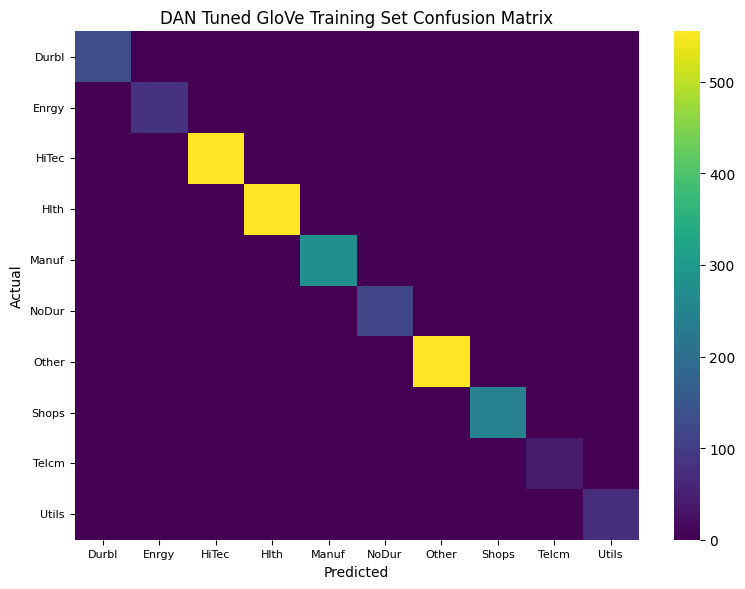

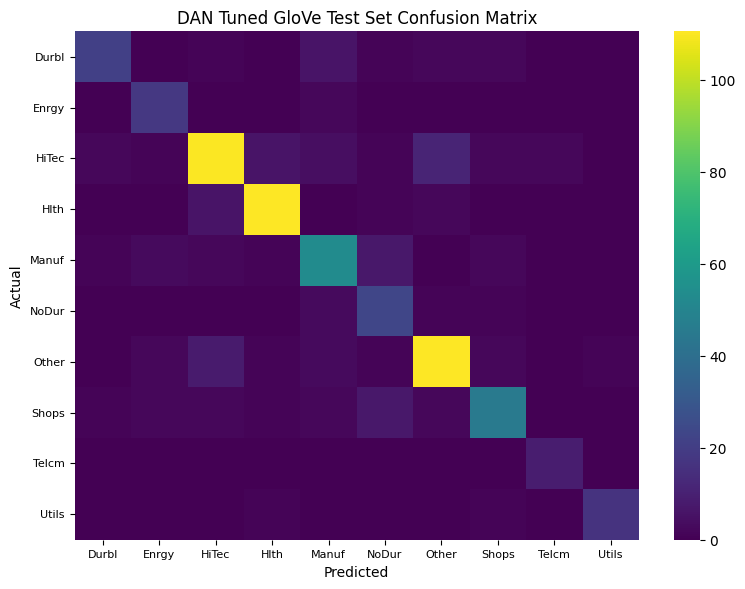

In [71]:
for num, (title, cf) in enumerate({'Training': cf_train,
                                   'Test': cf_test}.items()):
    fig, ax = plt.subplots(num=1+num, clear=True, figsize=(8, 6))
    sns.heatmap(cf, ax=ax, annot= False, fmt='d', cmap='viridis', robust=True,
                yticklabels=class_encoder.classes_,
                xticklabels=class_encoder.classes_)
    ax.set_title(f'DAN Tuned GloVe {title} Set Confusion Matrix')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.yaxis.set_tick_params(labelsize=8, rotation=0)
    ax.xaxis.set_tick_params(labelsize=8, rotation=0)
    plt.subplots_adjust(left=0.35, bottom=0.25)
    plt.tight_layout()

Initially, embeddings are frozen, then fine-tuned, with dropout introduced last, to highlight generalization improvements and the challenge of overfitting.


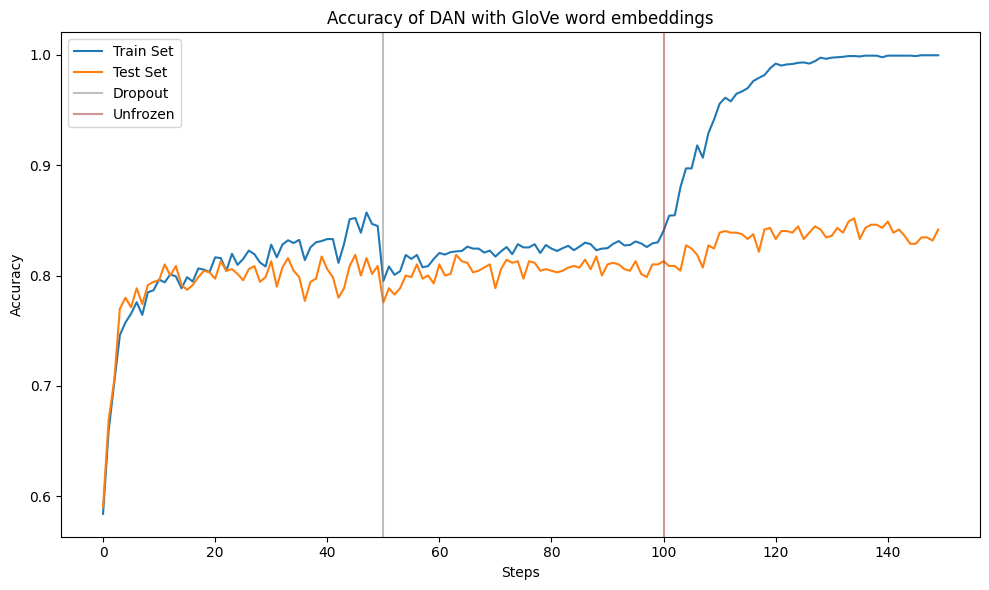

In [72]:
train_accuracy = pd.concat([Series([epoch['train'] for epoch in acc.values()])
                            for acc in accuracy],
                           ignore_index=True)
test_accuracy = pd.concat([Series([epoch['test'] for epoch in acc.values()])
                           for acc in accuracy],
                          ignore_index=True)

fig, ax = plt.subplots(num=1, clear=True, figsize=(10, 6))
train_accuracy.plot(ax=ax)
test_accuracy.plot(ax=ax)
ax.axvline(len(accuracy[0]), c='grey', alpha=0.5)
ax.axvline(len(accuracy[0]) + len(accuracy[1]), c='brown', alpha=0.5)
ax.set_title(f'Accuracy of DAN with GloVe word embeddings')
ax.set_xlabel('Steps')
ax.set_ylabel('Accuracy')
ax.legend(['Train Set', 'Test Set','Dropout', 'Unfrozen'], loc='upper left')
plt.tight_layout()

When embeddings are frozen, the model overfits the training data, achieving 100% training accuracy.  When dropout regularization is enabled, the test set accuracy slightly improves.

In [73]:
# Accuracy when frozen embeddings, unfrozen and with dropouts
p = (len(accuracy[0]) - 1, len(accuracy[0]) + len(accuracy[1]) - 1, -1)
print("Accuracy")
DataFrame({'frozen': [train_accuracy.iloc[p[0]], test_accuracy.iloc[p[0]]], 
           'dropout': [train_accuracy.iloc[p[1]], test_accuracy.iloc[p[1]]], 
           'unfrozen': [train_accuracy.iloc[p[2]], test_accuracy.iloc[p[2]]]},
          index=['train', 'test'])

Accuracy


,frozen,dropout,unfrozen
train,0.844908,0.830155,0.999640
test,0.808633,0.810072,0.841727


**References:**


Geoffrey E. Hinton, Nitish Srivastava, Alex Krizhevsky, Ilya Sutskever, 
Ruslan R. Salakhutdinov, July 2012, "Improving neural networks by preventing 
co-adaptation of feature detectors"

Jeffrey Pennington, Richard Socher, and Christopher D. Manning. 2014. GloVe: Global Vectors for Word Representation.

Tomas Mikolov, Kai Chen, Greg Corrado, Jeffrey Dean, 2013, "Efficient Estimation of Word Representations in Vector Space"

Greg Durrett, 2021-2024, "CS388 Natural Language Processing course materials", retrieved from https://www.cs.utexas.edu/~gdurrett/courses/online-course/materials.html

Philipp Krähenbühl, 2020-2024, "AI394T Deep Learning course materials", retrieved from
https://www.philkr.net/dl_class/material and https://ut.philkr.net/deeplearning/

Philipp Krähenbühl, 2025, "AI395T Advances in Deep Learning course materials", retrieved from https://ut.philkr.net/advances_in_deeplearning/